# Image Recognition
In this, we will train a convolutional neural network model to classify images (CIFAR10 dataset) using PyTorch.

In [1]:
# Import modules
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
# Define device for torch as GPU to utilize cuda tensor types instead of cpu tensor types
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Apply transformations, first resize numpy array to 32x32, Horizontal flip, Rotate, shear/scale, adjust coler, convert numpy array to tensor, last normalize using mean and std vectors
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

# Apply transformations, first resize numpy array to 32x32, convert numpy array to tensor, last normalize using mean and std vectors
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])
# Download and Load CIFAR10 training dataset and apply image transformations to transform from numpy array to Tensor
training_dataset = datasets.CIFAR10(root='./data_images', train=True, download=True, transform=transform_train)
# Validation Dataset
validation_dataset = datasets.CIFAR10(root='./data_images', train=False, download=True, transform=transform)
# Load a batch of 100 shuffled images from dataset to reduce the load on GPU
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
# Validation Dataloader
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Convert image from tensor to numpy array for plotting
def im_convert(tensor):
    # Copy tensor and convert to numpy
    image = tensor.clone().detach().numpy()
    # Change 1x28x28 dimensions to 28x28x1
    image = image.transpose(1, 2, 0)
    # De-normalize the image using the same mean and std
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    # To make sure the range of image pixels is between 0 and 1
    image = image.clip(0, 1)
    return image

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

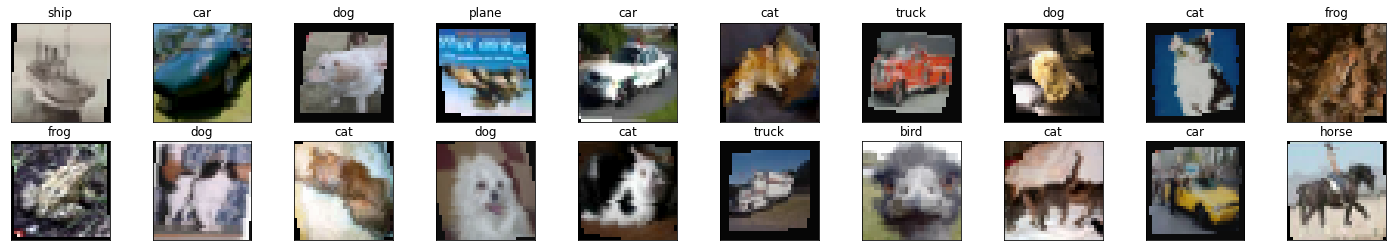

In [6]:
# Iterate through each batch of images
dataiter = iter(training_loader)
# Get first batch of images and labels
images, labels = next(dataiter)
# Create a figure to plot
fig = plt.figure(figsize=(25, 4))
# Plot the first 20 images in 2 row
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [7]:
# Define the Classifier using convolutional layers
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Define first convolutional layer with 3 input (RGB images), 16 output, 3 kernel size, 1 stride length
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        # Define 2nd convolutional layer with 16 input, 32 output, 3 kernel size, 1 stride length
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        # Define 3rd convolutional layer with 32 input, 64 output, 3 kernel size, 1 stride length
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        # Define 1st fully connected layer (32x32 -conv1> 32x32 -pool1> 16x16 -conv2> 16x16 -pool2> 8x8 -conv3> 8x8 -pool3> 4x4)
        self.fc1 = nn.Linear(4*4*64, 500)
        # Define dropout function to reduce the overfitting
        self.dropout1 = nn.Dropout(0.5)
        # Define 2nd fully connected layer
        self.fc2 = nn.Linear(500, 10)

    # Define the forward function using ReLu activation function
    def forward(self, x):
        # First input will be passed to first convolutional layer
        pred = F.relu(self.conv1(x))
        # Next the output from 1st conv layer will be passed to 1st pooling layer with 2x2 pooling kernel
        pred = F.max_pool2d(pred, 2, 2)

        # Next the output from 1st pooling layer will be passed to 2nd convolutional layer
        pred = F.relu(self.conv2(pred))
        # Next the output from 2nd conv layer will be passed to 2nd pooling layer with 2x2 pooling kernel
        pred = F.max_pool2d(pred, 2, 2)

        # Next the output from 2nd pooling layer will be passed to 3rd convolutional layer
        pred = F.relu(self.conv3(pred))
        # Next the output from 3rd conv layer will be passed to 3rd pooling layer with 2x2 pooling kernel
        pred = F.max_pool2d(pred, 2, 2)

        # Flatten the output from 3rd pooling layer
        pred = pred.view(-1, 4*4*64)
        # Pass the flattened output to 1st fully connected layer
        pred = F.relu(self.fc1(pred))
        # Use the Dropout function
        pred = self.dropout1(pred)
        # Pass the output from 1st fc layer to 2nd fc layer with no activation function
        pred = self.fc2(pred)
        return pred

In [8]:
# Initialize the Classifier
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
# Learning Rate effects the convergence and also accuracy, lower LR needs more epochs to converge, higher LR reduces accuracy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 15
train_losses = []
train_predicts = []
val_losses = []
val_predicts = []
for e in range(epochs):
    train_loss = 0.0
    train_predict = 0.0
    val_loss = 0.0
    val_predict = 0.0
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get the max score for each image in the batch
        _, preds = torch.max(outputs, 1)
        # Compare the max score with actual label value for each image in the batch
        train_predict += torch.sum(preds == labels.data)
        # Append loss for each batch
        train_loss += loss.item()
    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model.forward(val_inputs)
                v_loss = criterion(val_outputs, val_labels)

                # Get the max score for each image in the batch
                _, val_preds = torch.max(val_outputs, 1)
                # Compare the max score with actual label value for each image in the batch
                val_predict += torch.sum(val_preds == val_labels.data)
                # Append loss for each batch
                val_loss += v_loss.item()

        # Calculate average loss for batch
        train_epoch_loss = train_loss/len(training_loader.dataset)
        # Calculate average accuracy for batch
        train_epoch_acc = train_predict.float()/len(training_dataset)
        train_losses.append(train_epoch_loss)
        train_predicts.append(train_epoch_acc)

         # Calculate average loss for batch
        val_epoch_loss = val_loss/len(validation_loader.dataset)
        # Calculate average accuracy for batch
        val_epoch_acc = val_predict.float()/len(validation_dataset)
        val_losses.append(val_epoch_loss)
        val_predicts.append(val_epoch_acc)
        print('epoch:', (e+1))
        print('training loss {:.4f}, acc {:.4f}'.format(train_epoch_loss, train_epoch_acc.item()))
        print('validation loss {:.4f}, acc {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss 0.0168, acc 0.3825
validation loss 0.0140, acc 0.4855
epoch: 2
training loss 0.0138, acc 0.5034
validation loss 0.0124, acc 0.5511
epoch: 3
training loss 0.0125, acc 0.5509
validation loss 0.0114, acc 0.5959
epoch: 4
training loss 0.0116, acc 0.5849
validation loss 0.0107, acc 0.6207
epoch: 5
training loss 0.0110, acc 0.6106
validation loss 0.0098, acc 0.6618
epoch: 6
training loss 0.0105, acc 0.6317
validation loss 0.0094, acc 0.6693
epoch: 7
training loss 0.0101, acc 0.6461
validation loss 0.0093, acc 0.6776
epoch: 8
training loss 0.0098, acc 0.6593
validation loss 0.0090, acc 0.6883
epoch: 9
training loss 0.0094, acc 0.6672
validation loss 0.0086, acc 0.6989
epoch: 10
training loss 0.0093, acc 0.6753
validation loss 0.0085, acc 0.7055
epoch: 11
training loss 0.0090, acc 0.6864
validation loss 0.0085, acc 0.7015
epoch: 12
training loss 0.0088, acc 0.6923
validation loss 0.0082, acc 0.7176
epoch: 13
training loss 0.0087, acc 0.6929
validation loss 0.0080, acc 0.

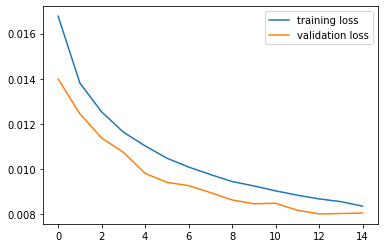

In [11]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

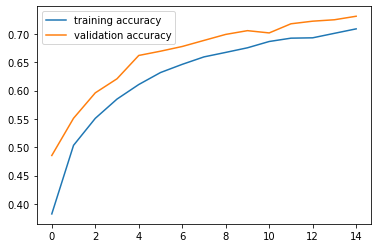

In [12]:
# lr=0.0001 -> training acc 0.6562, validation acc 0.6328
# lr=0.001 -> training acc 0.8315, validation acc 0.6912
# Adding 3rd conv & pool layer -> training acc 0.8337, validation acc 0.7112
# After image augmentation -> training acc 0.7087, validation acc 0.7309
plt.plot(train_predicts, label='training accuracy')
plt.plot(val_predicts, label='validation accuracy')
plt.legend()

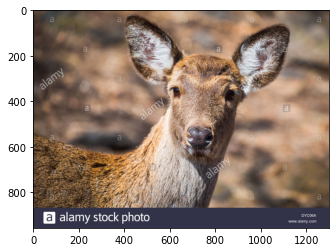

In [13]:
import requests
import PIL
from PIL import Image
url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

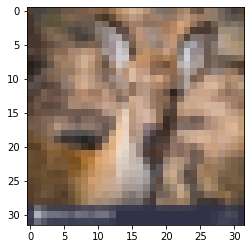

In [14]:
# Transform image: resize 28x28, convert to tensor and normalize
img = transform(img)
plt.imshow(im_convert(img))

In [15]:
# Convert the image to match with model input
inp = img.to(device).unsqueeze(0)
# Predict the digit in the image
output = model.forward(inp)
# Find the index of the max score
val, idx = torch.max(output, 1)
print(val.item(), classes[idx.item()])

3.9274189472198486 deer


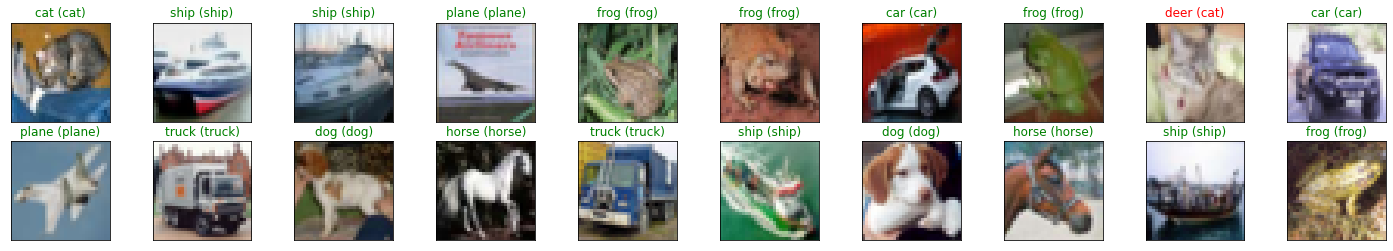

In [16]:
# Iterate through each batch of images
dataiter = iter(validation_loader)
# Get first batch of images and labels
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model.forward(images)
vals, preds = torch.max(output, 1)
# Create a figure to plot
fig = plt.figure(figsize=(25, 4))
# Plot the first 20 images in 2 row
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    # convert image tensor to cpu tensor for plotting
    plt.imshow(im_convert(images[idx].cpu()))
    ax.set_title('{} ({})'.format(classes[preds[idx].item()], classes[labels[idx].item()]), color='green' if (preds[idx] == labels[idx]) else 'red')